In [46]:
import pandas as pd
import numpy as np
import jellyfish
from collections import deque, defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, GlobalMaxPooling1D, Dropout, Bidirectional, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import json
from sklearn.metrics import confusion_matrix, classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [47]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))
print("TensorFlow version: ", tf.__version__)

Num GPUs Available:  1
Num CPUs Available:  1
TensorFlow version:  2.18.0


In [48]:
df = pd.read_csv("final.csv")
print(df.sample(n=20))

    Correct_Word Incorrect_Word                     Error_Type  Letter_Count  \
432         hair           hare  Letter-Phoneme Correspondence             4   
344        watch           wach  Letter-Phoneme Correspondence             5   
122         face          facce            Addition of Letters             4   
247        queen           quen            Omission of Letters             5   
67          wash           wosh  Letter-Phoneme Correspondence             4   
488         save           saev                 Transpositions             4   
21          ship            sip  Letter-Phoneme Correspondence             4   
176      kitchen        kitcehn                 Transpositions             7   
397      brother       brotheer            Addition of Letters             7   
224         book            bok            Omission of Letters             4   
379        shine           sine  Letter-Phoneme Correspondence             5   
290        train          traan  Letter-

In [49]:
class DataProcessor:
    def __init__(self, dataset_path):
        self.df = pd.read_csv(dataset_path)
        self.df = self.clean_dataset(self.df)
        self.correct_words = set(self.df['Correct_Word'].str.lower())
        self.incorrect_words = set(self.df['Incorrect_Word'].str.lower())
        self.all_words = pd.concat([self.df['Incorrect_Word'], self.df['Correct_Word']]).unique()
        self.unique_words = len(set(self.all_words))
        self._create_char_encoding()
        self.df['Error_Type'] = self.df['Error_Type'].apply(lambda x: x.split(',') if ',' in x else [x])
        self.error_types = sorted(set([et for sublist in self.df['Error_Type'] for et in sublist]))
        self.label_encoder = {et: i for i, et in enumerate(self.error_types)}
        self.inverse_label_encoder = {i: et for et, i in self.label_encoder.items()}
        self.max_difficulty = self.df['Difficulty_Level'].max()
        self.error_type_counts = {et: sum(1 for errors in self.df['Error_Type'] for e in errors if e == et)
                                 for et in self.error_types}

        print(f"Dataset rows without duplicate: {len(self.df)}")
        print(f"Error types: {self.error_types}")
        print(f"max difficulty: {self.max_difficulty}")
        print("Error type counts:")
        for et, count in self.error_type_counts.items():
            print(f"  {et}: {count}")

    def _create_char_encoding(self):
        chars = set(''.join(self.all_words))
        self.char_to_int = {c: i+1 for i, c in enumerate(chars)}
        self.int_to_char = {i: c for c, i in self.char_to_int.items()}
        self.max_length = int(np.percentile([len(word) for word in self.all_words], 95))

    def preprocess_word(self, word):
        processed = word.lower().ljust(self.max_length)[:self.max_length]
        return [self.char_to_int.get(c, 0) for c in processed]

    def decode_word(self, encoded_word):
        return ''.join([self.int_to_char.get(c, '') for c in encoded_word if c != 0])

    def phonetic_features(self, word):
        word = word.lower()
        correct_word = self.df[self.df['Incorrect_Word'] == word]['Correct_Word'].iloc[0] \
            if word in self.df['Incorrect_Word'].values else word

        edits = jellyfish.levenshtein_distance(word, correct_word)

        transposition_flag = any(word[i:i+2] == correct_word[i+1:i-1:-1] for i in range(len(word)-1)) and len(word) == len(correct_word)

        omission_flag = len(word) < len(correct_word)
        addition_flag = len(word) > len(correct_word)

        soundex_match = jellyfish.soundex(word) == jellyfish.soundex(correct_word)
        metaphone_match = jellyfish.metaphone(word) == jellyfish.metaphone(correct_word)
        nysiis_match = jellyfish.nysiis(word) == jellyfish.nysiis(correct_word)

        phoneme_mismatch_flag = not metaphone_match and not transposition_flag

        silent_letter_candidates = ['b', 'g', 'h', 'k', 'l', 'n', 'p', 't', 'w']

        silent_letter_flag = False
        if edits > 0 and soundex_match and not omission_flag and not addition_flag:
            silent_letter_flag = True
        elif edits > 0:
            word_set = set(word)
            correct_set = set(correct_word)
            missing_letters = correct_set - word_set
            silent_letter_flag = any(letter in silent_letter_candidates for letter in missing_letters)

        common_substitutions = [
            ('f', 'ph'), ('f', 'gh'), ('k', 'ch'), ('k', 'q'),
            ('s', 'c'), ('z', 's'), ('j', 'g'), ('ee', 'ea'),
            ('i', 'y'), ('ks', 'x'), ('shun', 'tion'), ('kw', 'qu')
        ]

        substitution_flag = False
        for sub_pair in common_substitutions:
            if (sub_pair[0] in word and sub_pair[1] in correct_word) or (sub_pair[1] in word and sub_pair[0] in correct_word):
                substitution_flag = True
                break

        doubled_letter_flag = False
        for i in range(len(word)-1):
            if word[i] == word[i+1]:
                if i+1 >= len(correct_word) or i >= len(correct_word) or word[i] != correct_word[i] or word[i+1] != correct_word[i+1]:
                    doubled_letter_flag = True
                    break

        vowels = 'aeiou'
        vowel_confusion = False
        word_vowels = [c for c in word if c in vowels]
        correct_vowels = [c for c in correct_word if c in vowels]
        if len(word_vowels) != len(correct_vowels) or ''.join(word_vowels) != ''.join(correct_vowels):
            vowel_confusion = True

        return np.array([
            edits,
            transposition_flag,
            omission_flag,
            addition_flag,
            phoneme_mismatch_flag,
            silent_letter_flag,
            substitution_flag,
            doubled_letter_flag,
            vowel_confusion,
            int(not soundex_match),
            int(not metaphone_match),
            int(not nysiis_match)
        ], dtype=float)

    def get_difficulty(self, word):
        return self.df[self.df['Incorrect_Word'] == word]['Difficulty_Level'].iloc[0] \
            if word in self.df['Incorrect_Word'].values else 0

    def suggest_words_by_difficulty(self, difficulty, count=5):
        return self.df[self.df['Difficulty_Level'] == difficulty]['Incorrect_Word'].sample(min(count, len(self.df[self.df['Difficulty_Level'] == difficulty]))).tolist()

    def clean_dataset(self, df):
        df.loc[df['Incorrect_Word'] == df['Correct_Word'], 'Error_Type'] = ['Correct']
        return df.drop_duplicates(subset=['Incorrect_Word', 'Correct_Word'], keep='first')



In [50]:
class DifficultyManager:
    def __init__(self):
        self.difficulty = 1
        self.performance = deque(maxlen=10)

    def update(self, correct):
        self.performance.append(correct)
        success_rate = np.mean(self.performance) if len(self.performance) > 0 else 0
        if success_rate > 0.7:
            self.difficulty = min(5, self.difficulty + 1)
        elif success_rate < 0.3:
            self.difficulty = max(1, self.difficulty - 1)

class GameEngine:
    def __init__(self):
        self.score = 0
        self.streak = 0
        self.level = 1

    def update(self, correct, difficulty):
        if correct:
            self.streak += 1
            self.score += (10 * difficulty) + (5 * self.streak)
            if self.score >= self.level * 100:
                self.level = min(10, self.level + 1)
        else:
            self.streak = 0
            self.score = max(0, self.score - (2 * difficulty))
            if self.score < (self.level - 1) * 100:
                self.level = max(1, self.level - 1)

In [51]:
class SpellingTutor:
    def __init__(self, dataset_path=None, filepath=None, metadata_path=None):
        if dataset_path is None and (filepath is not None or metadata_path is not None):
            raise ValueError("Dataset path must be provided")

        self.processor = DataProcessor(dataset_path) if dataset_path else None
        self.difficulty_manager = DifficultyManager()
        self.game = GameEngine()
        self.dataset_path = dataset_path
        self.filepath = filepath
        self.metadata_path = metadata_path

        if filepath and metadata_path and dataset_path:
            self.load_model(filepath, metadata_path, dataset_path)
        elif dataset_path:
            train_df, val_df = train_test_split(self.processor.df, test_size=0.2, random_state=42)
            self.X_train_seq = np.array([self.processor.preprocess_word(w) for w in train_df['Incorrect_Word']])
            self.X_train_ph = np.array([self.processor.phonetic_features(w) for w in train_df['Incorrect_Word']])
            self.y_train_error = np.array([[1 if et in errors else 0 for et in self.processor.error_types]
                                          for errors in train_df['Error_Type']])
            self.y_train_diff = np.array(train_df['Difficulty_Level'])
            self.X_val_seq = np.array([self.processor.preprocess_word(w) for w in val_df['Incorrect_Word']])
            self.X_val_ph = np.array([self.processor.phonetic_features(w) for w in val_df['Incorrect_Word']])
            self.y_val_error = np.array([[1 if et in errors else 0 for et in self.processor.error_types]
                                        for errors in val_df['Error_Type']])
            self.y_val_diff = np.array(val_df['Difficulty_Level'])
            self.val_words = val_df['Incorrect_Word'].values

            self.model = self._build_model()
            self.history = self._train_model()
            self._validate()
            self._plot_training_history()
        else:
            raise ValueError("No dataset path provided")

    def _build_model(self):
        seq_inputs = Input(shape=(self.processor.max_length,))
        ph_inputs = Input(shape=(12,))
        x = Embedding(input_dim=len(self.processor.char_to_int)+1, output_dim=128, mask_zero=True)(seq_inputs)
        x = Bidirectional(LSTM(512, return_sequences=True, dropout=0.2))(x)
        x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2))(x)
        x = GlobalMaxPooling1D()(x)
        x = Concatenate()([x, ph_inputs])
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)

        error_output = Dense(len(self.processor.error_types), activation='sigmoid', name='error_output')(x)
        diff_output = Dense(1, activation='linear', name='diff_output')(x)

        model = Model(inputs=[seq_inputs, ph_inputs], outputs=[error_output, diff_output])
        model.compile(
            loss={'error_output': 'binary_crossentropy', 'diff_output': 'mse'},
            optimizer=Adam(learning_rate=0.001),
            metrics={'error_output': 'accuracy', 'diff_output': 'mae'}
        )
        return model

    def _train_model(self):
        history = self.model.fit(
            [self.X_train_seq, self.X_train_ph],
            {'error_output': self.y_train_error, 'diff_output': self.y_train_diff},
            epochs=100, batch_size=32,
            validation_data=([self.X_val_seq, self.X_val_ph],
                            {'error_output': self.y_val_error, 'diff_output': self.y_val_diff}),
            callbacks=[EarlyStopping(patience=15, restore_best_weights=True),
                       ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss')],
            verbose=1
        )
        self.model.save('spelling_tutor_model.keras')

        metadata = {
            'dataset_path': self.dataset_path,
            'char_to_int': self.processor.char_to_int,
            'max_length': self.processor.max_length,
            'correct_words': list(self.processor.correct_words),
            'label_encoder': self.processor.label_encoder,
            'inverse_label_encoder': {str(k): v for k, v in self.processor.inverse_label_encoder.items()},
        }
        with open('spelling_tutor_metadata.json', 'w') as f:
            json.dump(metadata, f)
        return history

    def load_model(self, filepath, metadata_path, dataset_path):
        self.model = load_model(filepath)
        with open(metadata_path, 'r') as f:
            metadata = json.load(f)
            if 'dataset_path' in metadata and metadata['dataset_path'] != dataset_path:
                print(f"Warning: Provided dataset_path ({dataset_path}) differs from metadata ({metadata['dataset_path']})")
            self.processor.char_to_int = metadata['char_to_int']
            self.processor.max_length = metadata['max_length']
            self.processor.correct_words = set(metadata['correct_words'])
            self.processor.label_encoder = metadata['label_encoder']
            self.processor.inverse_label_encoder = {int(k): v for k, v in metadata['inverse_label_encoder'].items()}

    def _validate(self):
        error_preds, diff_preds = self.model.predict([self.X_val_seq, self.X_val_ph])

        error_preds_binary = (error_preds > 0.5).astype(int)

        print("\n ---Error Type Classification Report---")
        print(classification_report(
            self.y_val_error,
            error_preds_binary,
            target_names=self.processor.error_types,
            zero_division=0
        ))

        print("\n ---Confusion Matrices---")
        mcm = multilabel_confusion_matrix(self.y_val_error, error_preds_binary)

        plt.figure(figsize=(15, 10))
        for i, (matrix, error_type) in enumerate(zip(mcm, self.processor.error_types)):
            plt.subplot(3, 3, i+1)
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Predicted Negative', 'Predicted Positive'],
                      yticklabels=['Actual Negative', 'Actual Positive'])
            plt.title(f'Confusion Matrix for {error_type}')
        plt.tight_layout()
        plt.savefig('confusion_matrices.png')
        plt.show()

        print("\n ---Difficulty Prediction---")
        diff_mae = np.mean(np.abs(diff_preds.flatten() - self.y_val_diff))
        print(f"Validation Difficulty MAE: {diff_mae:.2f}")

    def _plot_training_history(self):
        plt.figure(figsize=(12, 8))

        plt.subplot(2, 2, 1)
        plt.plot(self.history.history['error_output_accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_error_output_accuracy'], label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()

        plt.subplot(2, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(2, 2, 3)
        plt.plot(self.history.history['error_output_loss'], label='Error Classification Loss')
        plt.plot(self.history.history['val_error_output_loss'], label='Val Error Classification Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Error Classification Loss')
        plt.legend()

        plt.subplot(2, 2, 4)
        plt.plot(self.history.history['diff_output_loss'], label='Difficulty Prediction Loss')
        plt.plot(self.history.history['val_diff_output_loss'], label='Val Difficulty Prediction Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Difficulty Prediction Loss')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png')
        plt.show()

    def process_word(self, word):
        correct = word.lower() in self.processor.correct_words
        seq_input = np.array([self.processor.preprocess_word(word)])
        ph_input = np.array([self.processor.phonetic_features(word)])
        error_proba, diff_pred = self.model.predict([seq_input, ph_input])

        if correct:
            error_types = ['Correct']
            confidence = 1.0
            max_confidence_type = 'Correct'
            confidences = {'Correct': 1.0}
        else:
            error_types = [self.processor.inverse_label_encoder[i] for i, prob in enumerate(error_proba[0]) if prob > 0.3]
            confidences = {self.processor.inverse_label_encoder[i]: prob for i, prob in enumerate(error_proba[0]) if prob > 0.3}
            max_confidence_idx = np.argmax(error_proba[0])
            max_confidence_type = self.processor.inverse_label_encoder[max_confidence_idx]
            confidence = error_proba[0][max_confidence_idx]
            if not error_types:
                error_types = ['Unknown']
                confidences = {'Unknown': confidence}

        difficulty_pred = float(diff_pred[0][0])
        actual_difficulty = self.processor.get_difficulty(word) if not correct else 0

        self.difficulty_manager.update(correct)
        self.game.update(correct, self.difficulty_manager.difficulty)
        return {
            'word': word,
            'correct': correct,
            'error_types': error_types,
            'confidences': confidences,
            'max_confidence_type': max_confidence_type,
            'confidence': confidence,
            'predicted_difficulty': round(difficulty_pred, 2),
            'actual_difficulty': actual_difficulty,
            'game_difficulty': self.difficulty_manager.difficulty,
            'score': self.game.score,
            'level': self.game.level,
            'streak': self.game.streak
        }

Dataset rows without duplicate: 531
Error types: ['Addition of Letters', 'Letter-Phoneme Correspondence', 'Omission of Letters', 'Silent Letters', 'Transpositions']
max difficulty: 4
Error type counts:
  Addition of Letters: 108
  Letter-Phoneme Correspondence: 104
  Omission of Letters: 107
  Silent Letters: 106
  Transpositions: 106
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - diff_output_loss: 4.5757 - diff_output_mae: 1.8606 - error_output_accuracy: 0.2072 - error_output_loss: 0.7333 - loss: 5.3204 - val_diff_output_loss: 0.6409 - val_diff_output_mae: 0.7034 - val_error_output_accuracy: 0.2804 - val_error_output_loss: 0.6852 - val_loss: 1.3803
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - diff_output_loss: 0.5329 - diff_output_mae: 0.6009 - error_output_accuracy: 0.1958 - error_output_loss: 0.6630 - loss: 1.1983 - val_diff_output_loss: 0.2775 - val_diff_output_mae: 0.4080 - val_error_output_accuracy: 0.3271 - val_error_output_loss: 0.5755 - val_loss: 0.8519
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - diff_output_loss: 0.3577 - diff_output_mae: 0.4890 - error_output_accuracy: 0.2354 - error_output_loss: 0.5635 - loss: 0.9216 - val_diff_output_loss: 0.2411 - val_diff_output_mae: 0.3613 - val_error_output_accuracy: 0.2243 - val_error_output_loss: 0.5174 - val_loss: 0.7371
Epoch 4/100
14/14 ━━━━━━━━━

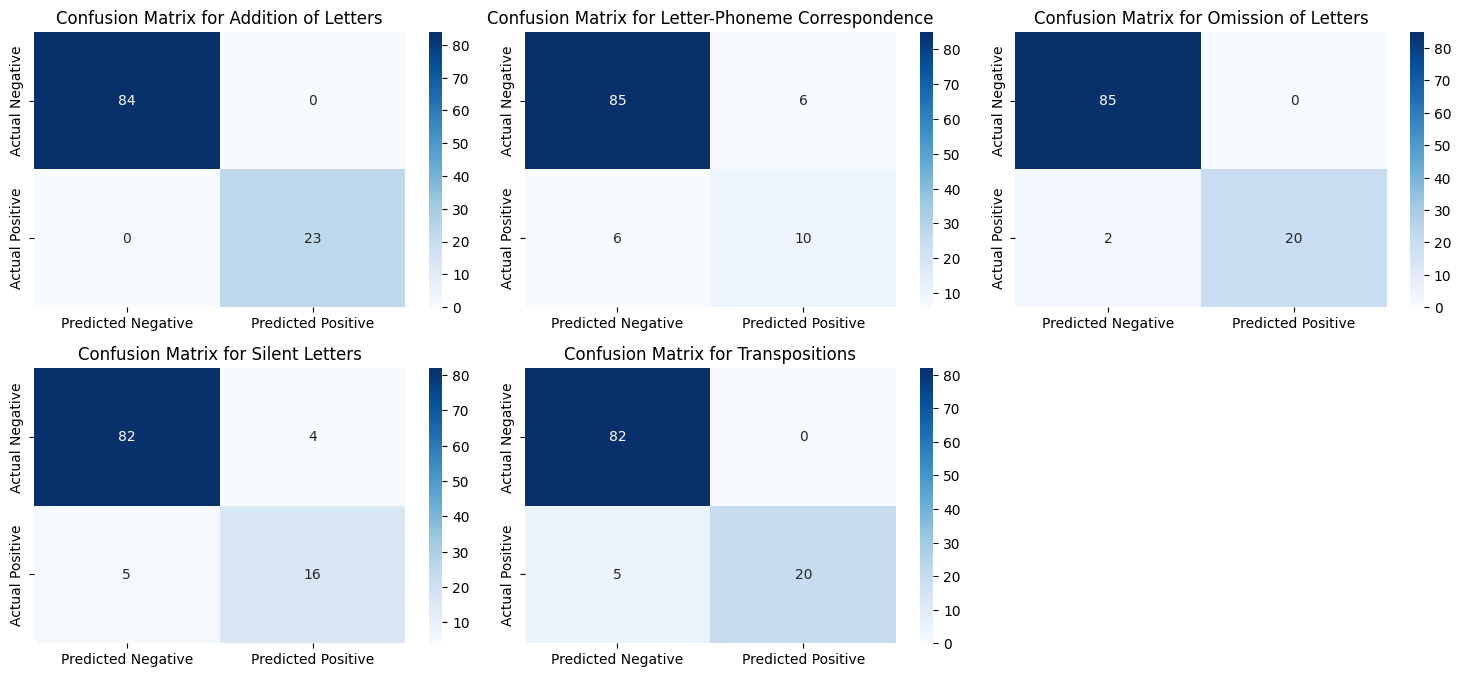


 ---Difficulty Prediction---
Validation Difficulty MAE: 0.31


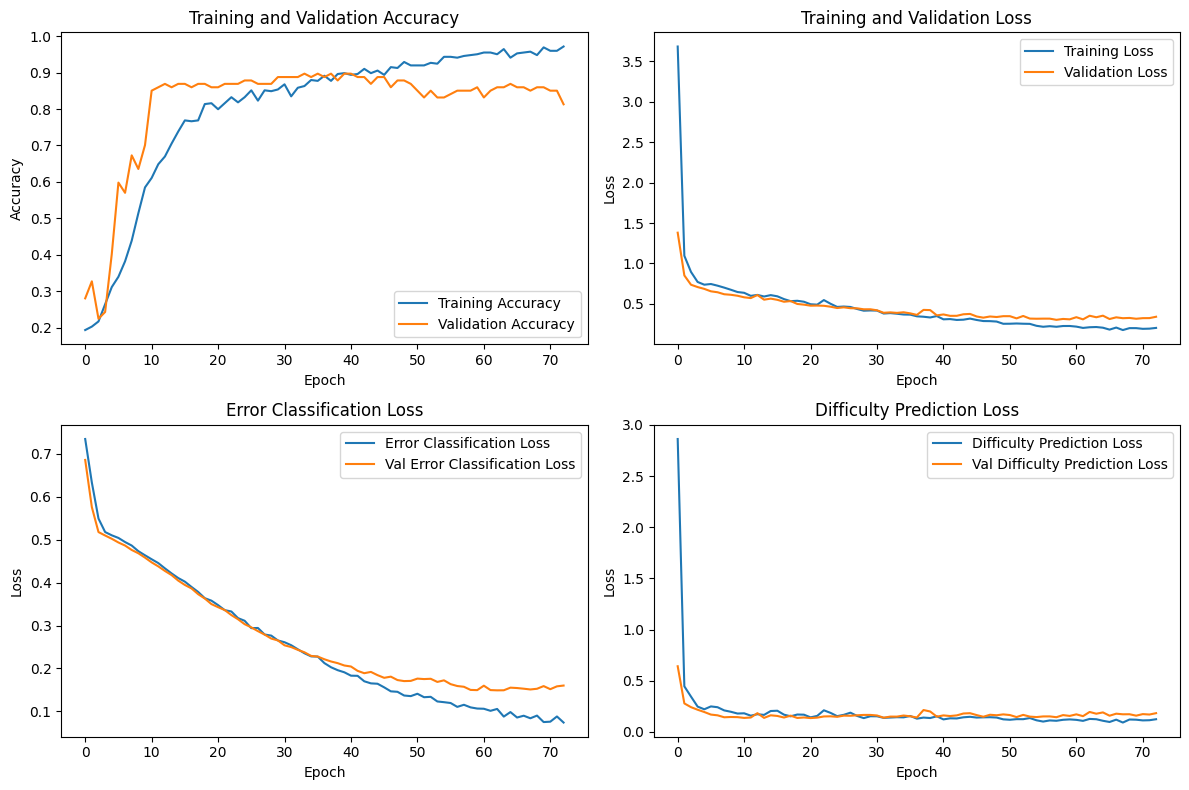

Model trained and saved!


In [52]:
tutor = SpellingTutor(dataset_path="final.csv")
print("Model trained and saved!")



In [53]:
tutor_loaded = SpellingTutor(
    dataset_path="final.csv",
    filepath="spelling_tutor_model.keras",
    metadata_path="spelling_tutor_metadata.json"
)
tutor_loaded.model.summary()

Dataset rows without duplicate: 531
Error types: ['Addition of Letters', 'Letter-Phoneme Correspondence', 'Omission of Letters', 'Silent Letters', 'Transpositions']
max difficulty: 4
Error type counts:
  Addition of Letters: 108
  Letter-Phoneme Correspondence: 104
  Omission of Letters: 107
  Silent Letters: 106
  Transpositions: 106


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'global_max_pooling1d_3' (of type GlobalMaxPooling1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 8)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, 8, 128)         │          3,712 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal_10 (NotEqual)   │ (None, 8)              │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_6           │ (None, 8, 1024)        │      2,625,536 │ embedding_3[0][0],     │
│ (Bidirectional)           │                        │                │ not_equal_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_7           │ (None, 8, 512)         │      2,623,488 │ bidirectional_6[0][0], │
│ (Bidirectional)           │                        │                │ not_equal_10[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d_3    │ (None, 512)            │              0 │ bidirectional_7[0][0]  │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 524)            │              0 │ global_max_pooling1d_… │
│ (Concatenate)             │                        │                │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         67,200 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_3 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ error_output (Dense)      │ (None, 5)              │            645 │ dropout_3[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ diff_output (Dense)       │ (None, 1)              │            129 │ dropout_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 15,962,132 (60.89 MB)

 Trainable params: 5,320,710 (20.30 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,641,422 (40.59 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

Word: nife
Status: ✗ Incorrect
Error Types: Letter-Phoneme Correspondence (65.41%), Silent Letters (36.97%)
Max Confidence Error Type: Letter-Phoneme Correspondence (65.41%)
Predicted Difficulty: 2.3 | Actual Difficulty: 2
Score: 0 | Streak: 0 | Game Difficulty: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Word: rite
Status: ✗ Incorrect
Error Types: Silent Letters (77.68%)
Max Confidence Error Type: Silent Letters (77.68%)
Predicted Difficulty: 2.36 | Actual Difficulty: 2
Score: 0 | Streak: 0 | Game Difficulty: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Word: mountan
Status: ✗ Incorrect
Error Types: Omission of Letters (50.55%)
Max Confidence Error Type: Omission of Letters (50.55%)
Predicted Difficulty: 4.06 | Actual Difficulty: 4
Score: 0 | Streak: 0 | Game Difficulty: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

Word: naw
Status: ✗ Incorrect
Error Types: Letter-Phoneme Correspondence (57.10%), Silent Letters (54.80%)
Max Confidence Error Type: Letter-Pho

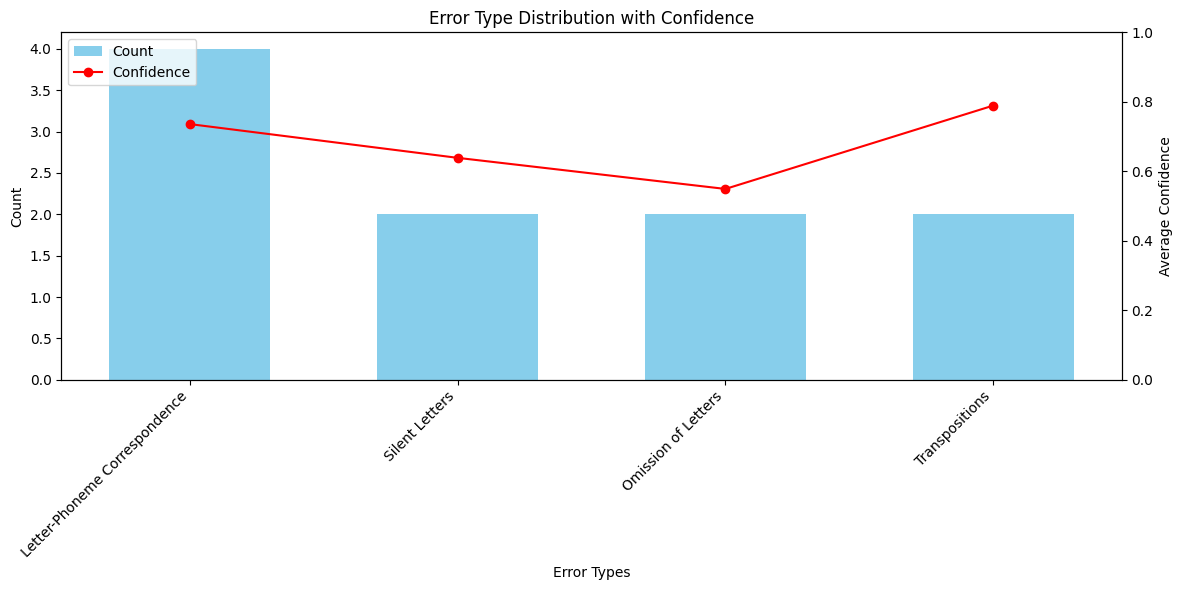

In [55]:
test_words = [
    'nife',
    'rite',
    'mountan',
    'naw',
    'freind',
    'fone',
    'sykology',
    'aline',
    'safary',
    'kitcehn'
]

results = []
previous_score = 0

for word in test_words:
    result = tutor_loaded.process_word(word)
    score_change = result['score'] - previous_score
    results.append({
        'word': result['word'],
        'correct': result['correct'],
        'error_types': result['error_types'],
        'confidences': result['confidences'],
        'max_confidence_type': result['max_confidence_type'],
        'confidence': result['confidence'],
        'predicted_difficulty': result['predicted_difficulty'],
        'actual_difficulty': result['actual_difficulty'],
        'score_change': score_change,
        'total_score': result['score'],
        'streak': result['streak'],
        'difficulty': result['game_difficulty']
    })
    previous_score = result['score']
    print(f"\nWord: {result['word']}")
    print(f"Status: {'✓ Correct' if result['correct'] else '✗ Incorrect'}")
    if not result['correct']:
        error_types_str = ', '.join([f"{et} ({result['confidences'][et]:.2%})" for et in result['error_types']])
        print(f"Error Types: {error_types_str}")
        print(f"Max Confidence Error Type: {result['max_confidence_type']} ({result['confidence']:.2%})")
    print(f"Predicted Difficulty: {result['predicted_difficulty']} | Actual Difficulty: {result['actual_difficulty']}")
    print(f"Score: {result['score']} | Streak: {result['streak']} | Game Difficulty: {result['game_difficulty']}")

grouped_results = defaultdict(lambda: {'count': 0, 'total_score_change': 0, 'words': [], 'avg_confidence': 0.0, 'total_difficulty': 0.0})

for result in results:
    if not result['correct']:
        error_type = result['max_confidence_type']
        grouped_results[error_type]['count'] += 1
        grouped_results[error_type]['total_score_change'] += result['score_change']
        grouped_results[error_type]['words'].append(result['word'])
        grouped_results[error_type]['avg_confidence'] += result['confidence']
        grouped_results[error_type]['total_difficulty'] += result['predicted_difficulty']

print("\n=== Results Analysis by Error Type ===")
for error_type, data in grouped_results.items():
    if data['count'] > 0:
        data['avg_confidence'] /= data['count']
        data['avg_difficulty'] = data['total_difficulty'] / data['count']
        rounded_difficulty_level = round(data['avg_difficulty'])

        print(f"Error Type: {error_type}")
        print(f"  Count: {data['count']}")
        print(f"  Average Confidence: {data['avg_confidence']:.2%}")
        print(f"  Average Difficulty: {data['avg_difficulty']:.2f}")
        print(f"  Words: {', '.join(data['words'])}")

        if hasattr(tutor_loaded, "processor") and hasattr(tutor_loaded.processor, "df"):
            error_type_words = tutor_loaded.processor.df[
                (tutor_loaded.processor.df['Error_Type'].apply(lambda x: error_type in x)) &
                (tutor_loaded.processor.df['Difficulty_Level'] == rounded_difficulty_level)
            ]

            if not error_type_words.empty:
                new_words = error_type_words[~error_type_words['Incorrect_Word'].isin(data['words'])]

                if not new_words.empty:
                    suggested_words = new_words['Incorrect_Word'].sample(min(5, len(new_words))).tolist()
                    print(f"  Suggested Words (Difficulty {rounded_difficulty_level}):")
                    for i, word in enumerate(suggested_words, 1):
                        difficulty = tutor_loaded.processor.get_difficulty(word)
                        correct_word = error_type_words[error_type_words['Incorrect_Word'] == word]['Correct_Word'].iloc[0]
                        print(f"    {i}. {word} (correct: {correct_word})")


if grouped_results:
    error_types = list(grouped_results.keys())
    error_counts = [grouped_results[et]['count'] for et in error_types]
    avg_confidences = [grouped_results[et]['avg_confidence'] for et in error_types]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    x = np.arange(len(error_types))
    bars = ax1.bar(x, error_counts, width=0.6, color='skyblue', label='Count')
    ax1.set_xlabel('Error Types')
    ax1.set_ylabel('Count')
    ax1.set_title('Error Type Distribution with Confidence')
    ax1.set_xticks(x)
    ax1.set_xticklabels(error_types, rotation=45, ha='right')

    ax2 = ax1.twinx()
    ax2.plot(x, avg_confidences, 'ro-', label='Confidence')
    ax2.set_ylabel('Average Confidence')
    ax2.set_ylim([0, 1])

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.tight_layout()
    plt.savefig('error_analysis.png')
    plt.show()